
Random Forest Results:
MSE: 0.5665
RMSE: 0.7527
MAE: 0.5314
R2: 0.6266
Cross-validated RMSE: 1.1735

Gradient Boosting Results:
MSE: 0.6970
RMSE: 0.8349
MAE: 0.6414
R2: 0.5406
Cross-validated RMSE: 1.2372

Gradient Boosting Results:
MSE: 0.6970
RMSE: 0.8349
MAE: 0.6414
R2: 0.5406
Cross-validated RMSE: 1.2372


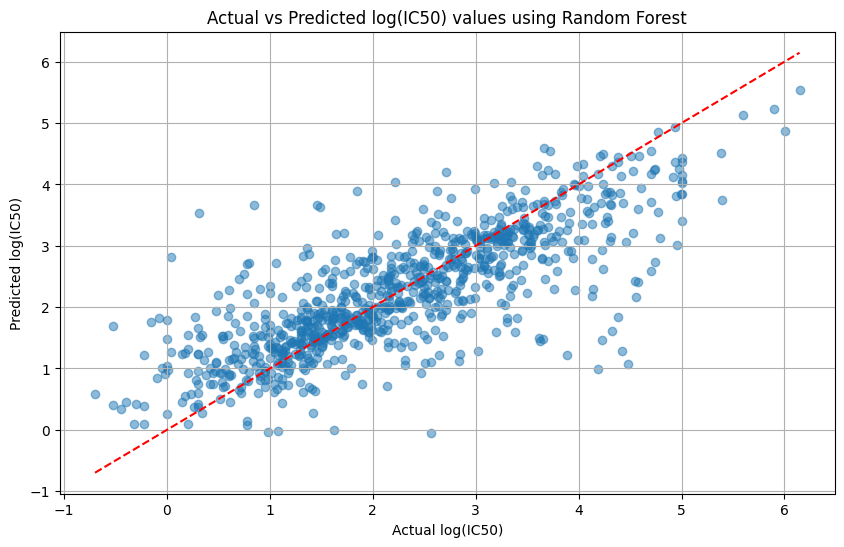

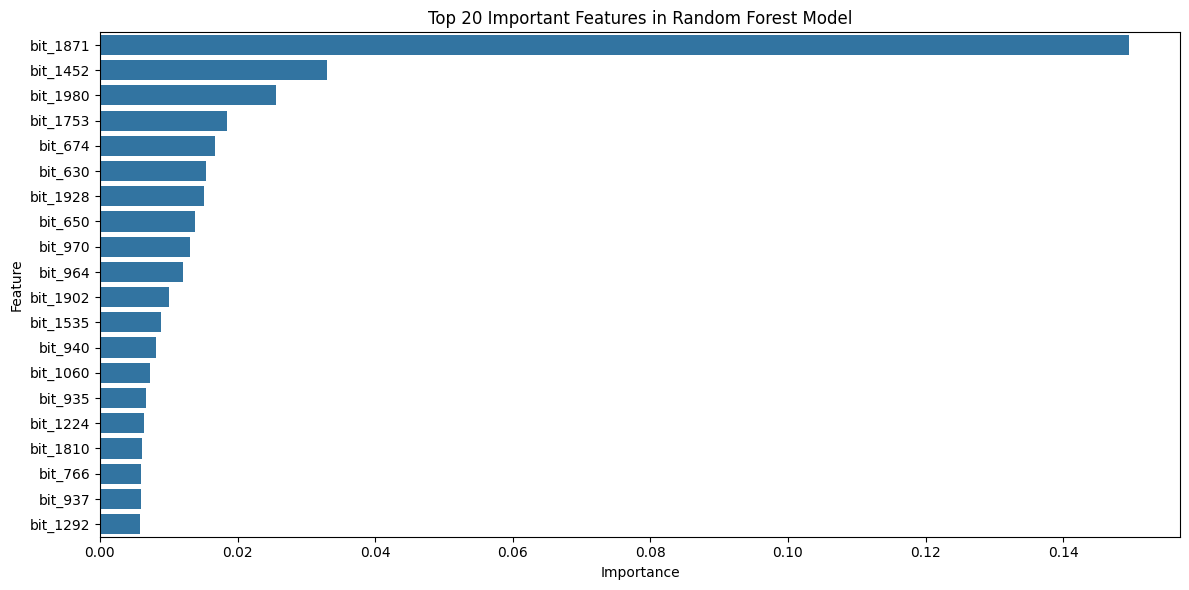

Analysis completed and enhanced dataset saved.


In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem, RDLogger
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.DataStructs import ConvertToNumpyArray
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Silence RDKit deprecation warnings
RDLogger.DisableLog('rdApp.*')

# Load the dataset
data = pd.read_csv('BACE1_data.csv')

# Use MorganGenerator for fingerprints (no deprecation warning)
radius, nBits = 2, 2048
gen = GetMorganGenerator(radius=radius, fpSize=nBits)

def smiles_to_morgan_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    bv = gen.GetFingerprint(mol)
    arr = np.zeros((nBits,), dtype=int)
    ConvertToNumpyArray(bv, arr)
    return arr.tolist()

# Apply the function to the SMILES column
data['Morgan_FP'] = data['Smiles'].apply(smiles_to_morgan_fp)

# Remove rows where Morgan fingerprint couldn't be generated
data = data.dropna(subset=['Morgan_FP'])

# Convert the list of fingerprints to separate columns
fp_df = pd.DataFrame(data['Morgan_FP'].tolist())
fp_df.columns = [f'bit_{i}' for i in range(fp_df.shape[1])]

# Combine the original dataframe with fingerprints
data_with_fp = pd.concat([data, fp_df], axis=1)

# Prepare features and target
X = data_with_fp[[col for col in data_with_fp.columns if 'bit_' in col]]
y = data_with_fp['IC50_nM']

# Optionally, transform IC50 values (often done in drug discovery)
y_log = np.log10(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Dictionary to store results
results = {}

# Train and evaluate models
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Perform cross-validation
    cv_scores = cross_val_score(model, X, y_log, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())
    
    # Store results
    results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'CV_RMSE': cv_rmse,
        'y_pred': y_pred,
        'model': model
    }
    
    print(f"\n{name} Results:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2: {r2:.4f}")
    print(f"Cross-validated RMSE: {cv_rmse:.4f}")

# Plot predicted vs actual values for the best model
best_model_name = max(results, key=lambda k: results[k]['R2'])
plt.figure(figsize=(10, 6))
plt.scatter(y_test, results[best_model_name]['y_pred'], alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual log(IC50)')
plt.ylabel('Predicted log(IC50)')
plt.title(f'Actual vs Predicted log(IC50) values using {best_model_name}')
plt.grid(True)
plt.show()

# Plot feature importance for Random Forest
if 'Random Forest' in results:
    rf_model = results['Random Forest']['model']
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title('Top 20 Important Features in Random Forest Model')
    plt.tight_layout()
    plt.show()

# Save the enhanced dataset with fingerprints
data_with_fp.to_csv('BACE1_data_with_fingerprints.csv', index=False)

print("Analysis completed and enhanced dataset saved.")

In [3]:
import pandas as pd
import numpy as np
from rdkit import Chem, RDLogger
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.DataStructs import ConvertToNumpyArray
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ─── 0. Silence RDKit logs ─────────────────────────────────────────────────────
RDLogger.DisableLog('rdApp.*')

# ─── 1. Load your BACE1 data ─────────────────────────────────────────────────
df = pd.read_csv('BACE1_data.csv')   # must contain columns 'Smiles' and 'IC50_nM'

# ─── 2. (Optional) Filter / clean / cap extremes ───────────────────────────────
# e.g., replace zeros or extremely large IC50s to avoid log(0)
df['IC50_nM'] = df['IC50_nM'].clip(lower=1e-3, upper=1e9)

# ─── 3. (Optional) Transform to pIC50 ─────────────────────────────────────────
# this often helps regression (more normal target distribution):
df['pIC50'] = -np.log10(df['IC50_nM'] * 1e-9)

# Choose your regression target here:
target_col = 'pIC50'   # or use 'IC50_nM' directly

# ─── 4. Setup Morgan fingerprint generator ────────────────────────────────────
radius, n_bits = 2, 1024
gen = GetMorganGenerator(radius=radius, fpSize=n_bits)

def smiles_to_morgan(smiles: str) -> np.ndarray:
    """Convert SMILES to a 1×n_bits Morgan fingerprint numpy array."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(n_bits, dtype=int)
    bv = gen.GetFingerprint(mol)            # ExplicitBitVect
    arr = np.zeros((n_bits,), dtype=int)    # pre-allocate
    ConvertToNumpyArray(bv, arr)
    return arr

# ─── 5. Compute fingerprint matrix and augment DataFrame ──────────────────────
fps = df['Smiles'].map(smiles_to_morgan).to_list()
fp_matrix = np.vstack(fps)
fp_cols    = [f'FP_{i}' for i in range(n_bits)]

df_fp = pd.concat([
    df.reset_index(drop=True),
    pd.DataFrame(fp_matrix, columns=fp_cols)
], axis=1)

# ─── 6. Save augmented CSV for later inspection ───────────────────────────────
df_fp.to_csv('BACE1_data_with_fp.csv', index=False)
print("👉 Augmented dataset saved as 'BACE1_data_with_fp.csv'")

# ─── 7. Prepare X, y and train/test split ────────────────────────────────────
X = fp_matrix
y = df_fp[target_col].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ─── 8. Train a Random Forest regressor ───────────────────────────────────────
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# ─── 9. Predict and evaluate ─────────────────────────────────────────────────
y_pred = model.predict(X_test)

print("\nTest set performance:")
print(f"  RMSE = {mean_squared_error(y_test, y_pred, squared=False):.3f}")
print(f"  MAE  = {mean_absolute_error(y_test, y_pred):.3f}")
print(f"  R²   = {r2_score(y_test, y_pred):.3f}")


👉 Augmented dataset saved as 'BACE1_data_with_fp.csv'

Test set performance:
  RMSE = 0.749
  MAE  = 0.534
  R²   = 0.630


c:\Users\sairo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
